# Data Preparation for EMNIST Letters Dataset

## Load the Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('../emnist-letters-train.csv')

# Check the shape and first few rows
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (64828, 785)


,24,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.552,0.553,0.554,0.555,0.556,0.557,0.558,0.559,0.560,0.561
0,-2,142,142,142,142,142,142,142,142,142,...,142,142,142,142,142,142,142,142,142,142
1,15,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,14,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,-2,120,120,120,120,120,120,120,120,120,...,120,120,120,120,120,120,120,120,120,120
4,-1,131,131,131,131,131,131,131,131,200,...,131,131,131,131,131,131,131,131,131,131


## Understanding the Data Structure

Unique labels: [-2 -1  1  2  4  5  6  7  9 10 12 14 15 16 17 20 24 26]
Label counts: [4856 5384 3396 3396 3398 3437 3394 3385 3428 3402 3415 3365 3408 3430
 3435 3436 3436 3427]


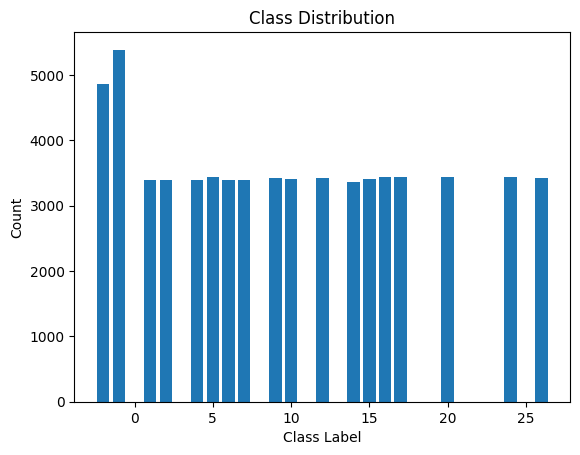

In [2]:
# Separate labels and pixel data
labels = data.iloc[:, 0].values
pixels = data.iloc[:, 1:].values

# Check label distribution
unique_labels, counts = np.unique(labels, return_counts=True)
print(f"Unique labels: {unique_labels}")
print(f"Label counts: {counts}")

# Visualize class distribution
plt.bar(unique_labels, counts)
plt.title('Class Distribution')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

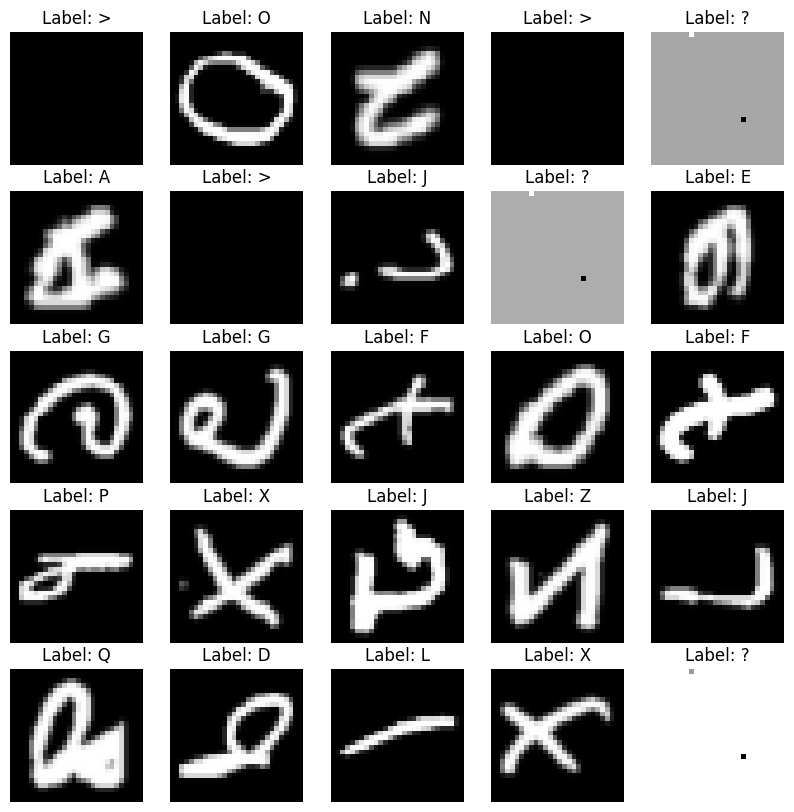

In [3]:
# Reshape and normalize
images = pixels.reshape(-1, 28, 28, 1).astype('float32')
images = (images - 127.5) / 127.5  # Normalize to [-1, 1]

# Visualize some samples
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(images[i].squeeze(), cmap='gray')
    plt.title(f"Label: {chr(labels[i]+64)}")
    plt.axis('off')
plt.show()

## Data Cleaning

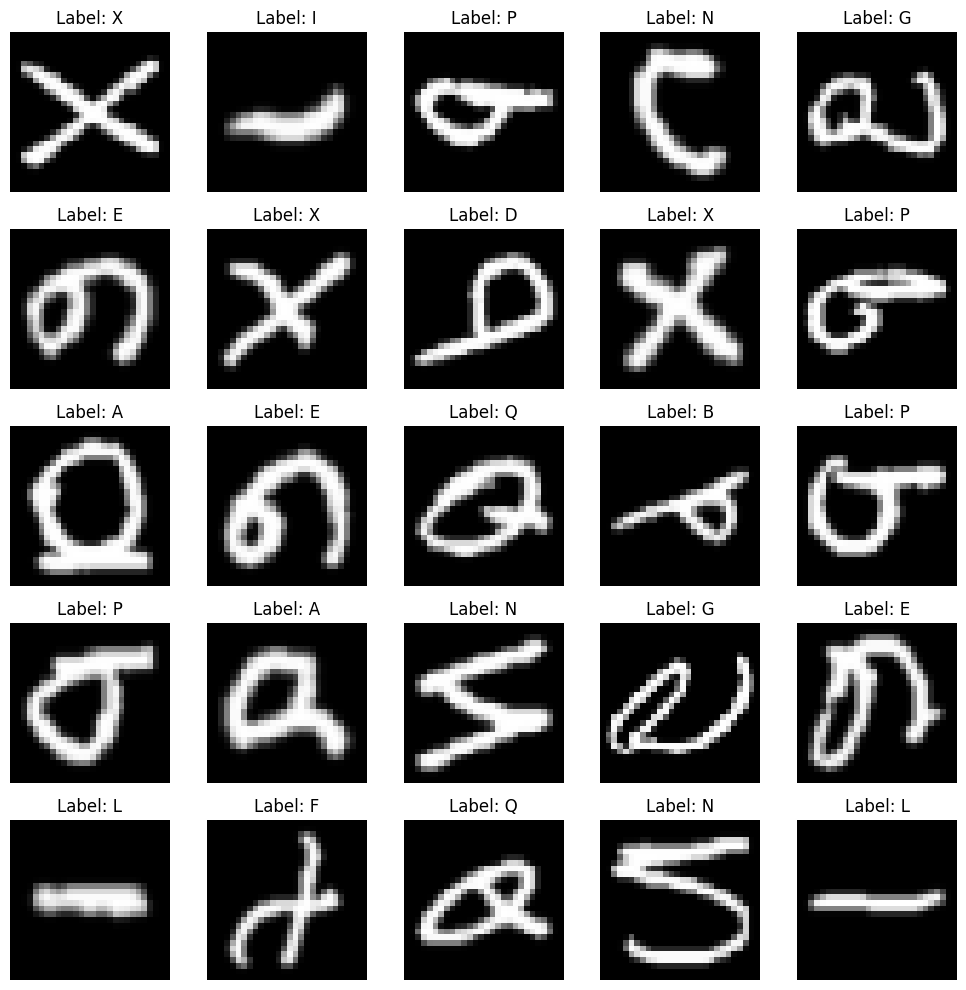

Total images after cleaning: 54588
Unique labels present: [ 1  2  4  5  6  7  9 10 12 14 15 16 17 20 24 26]
Corresponding letters: ['A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']


In [6]:
import matplotlib.pyplot as plt
import numpy as np

# First filter out negative labels
valid_mask = labels > 0
filtered_images = images[valid_mask]
filtered_labels = labels[valid_mask]

# Then select only our 16 target classes
selected_numeric = [1, 2, 4, 5, 6, 7, 9, 10, 12, 14, 15, 16, 17, 20, 24, 26]  # A,B,D,E,F,G,I,J,L,N,O,P,Q,T,X,Z
final_mask = np.isin(filtered_labels, selected_numeric)
final_images = filtered_images[final_mask]
final_labels = filtered_labels[final_mask]

# Visualize 25 random samples from the cleaned data
plt.figure(figsize=(10, 10))
indices = np.random.choice(len(final_images), 25, replace=False)  # Get 25 random unique indices

for i, idx in enumerate(indices):
    plt.subplot(5, 5, i+1)
    plt.imshow(final_images[idx].squeeze(), cmap='gray')
    plt.title(f"Label: {chr(final_labels[idx]+64)}")  # Convert numeric label to letter
    plt.axis('off')
    
plt.tight_layout()
plt.show()

# Print statistics
print(f"Total images after cleaning: {len(final_images)}")
print(f"Unique labels present: {np.unique(final_labels)}")
print(f"Corresponding letters: {[chr(l+64) for l in np.unique(final_labels)]}")

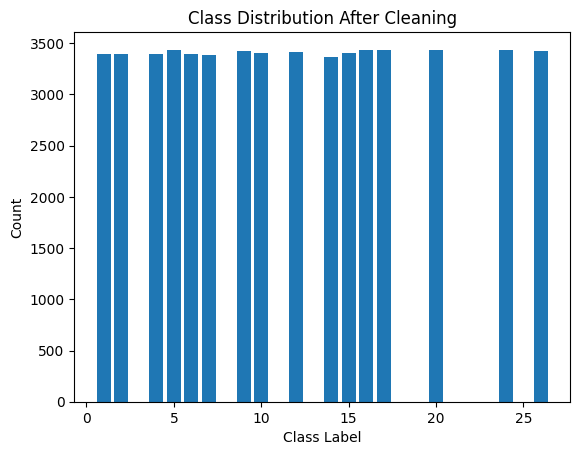

Unique labels after cleaning: [ 1  2  4  5  6  7  9 10 12 14 15 16 17 20 24 26]
Label counts after cleaning: [3396 3396 3398 3437 3394 3385 3428 3402 3415 3365 3408 3430 3435 3436
 3436 3427]
Corresponding letters: ['A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']


In [8]:
# Show class distribution after cleaning

unique_labels_cleaned, counts_cleaned = np.unique(final_labels, return_counts=True)
plt.bar(unique_labels_cleaned, counts_cleaned)
plt.title('Class Distribution After Cleaning')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

print(f"Unique labels after cleaning: {unique_labels_cleaned}")
print(f"Label counts after cleaning: {counts_cleaned}")
print(f"Corresponding letters: {[chr(l+64) for l in unique_labels_cleaned]}")


## Handling Class Imbalance (If Needed)

In [ ]:
# Calculate class imbalance ratio
class_ratio = counts.min() / counts.max()
print(f"Class imbalance ratio: {class_ratio:.2f}")

if class_ratio < 0.5:
    print("Significant class imbalance detected - consider techniques like:")
    print("- Oversampling minority classes")
    print("- Class weights in the discriminator")
    print("- Data augmentation for minority classes")

: 

: 

## Data Augmentation (Optional)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)

# Example of how to use it during training
augmented_images = datagen.flow(images, labels, batch_size=32)

: 

: 

## Preparing for Conditional GAN

In [ ]:
from tensorflow.keras.utils import to_categorical

# Convert labels to one-hot encoding (for 16 classes)
selected_letters = ['A', 'B', 'D', 'E', 'F', 'G', 'I', 'J', 
                   'L', 'N', 'O', 'P', 'Q', 'T', 'X', 'Z']

# Convert letters to their label values (A=1, B=2, ..., Z=26)
selected_labels = [ord(c) - 64 for c in selected_letters]

# Filter the dataset to only include these 16 classes
mask = np.isin(labels, selected_labels)
filtered_images = images[mask]
filtered_labels = labels[mask]

# Now convert to 0-15 range for one-hot encoding
label_mapping = {label: idx for idx, label in enumerate(selected_labels)}
mapped_labels = np.array([label_mapping[label] for label in filtered_labels])

# One-hot encode (now safe with 16 classes)
one_hot_labels = to_categorical(mapped_labels, num_classes=16)

: 

: 

## Final Dataset Preparation

In [ ]:
import tensorflow as tf

# Create TensorFlow Dataset - CONDITIONAL GAN VERSION
# Using the filtered and properly matched data
conditional_dataset = tf.data.Dataset.from_tensor_slices((filtered_images, one_hot_labels))
conditional_dataset = conditional_dataset.shuffle(
    buffer_size=min(1024, len(filtered_images)),  # Ensure buffer isn't larger than dataset
    reshuffle_each_iteration=True
).batch(32)

# Create TensorFlow Dataset - NON-CONDITIONAL GAN VERSION
# Using just the filtered images
image_dataset = tf.data.Dataset.from_tensor_slices(filtered_images)
image_dataset = image_dataset.shuffle(
    buffer_size=min(1024, len(filtered_images)),
    reshuffle_each_iteration=True
).batch(32)

# Optional: Prefetch for better performance during training
conditional_dataset = conditional_dataset.prefetch(tf.data.AUTOTUNE)
image_dataset = image_dataset.prefetch(tf.data.AUTOTUNE)

: 

: 